In [3]:
import pandas as pd
import numpy as np

In [4]:
trade_bra = pd.read_csv('data/trade_bra.csv', dtype = {'HS ID 4': str}).dropna(subset = ['Exports', 'Imports'])
wages_bra = pd.read_csv('data/wages_bra.csv').dropna(subset = ['Total Jobs', 'Total Yearly Wages'])

# wages_bra_raw = wages_bra_raw.sample(frac = .)

In [5]:
def filter_small_cats(df, level, cat = 'BRA ID MIR', col = 'Total Yearly Wages'):
    grouped = df.groupby(cat).sum().sort_values(by = col, ascending = False).dropna()
    cumsum = grouped.div(grouped.sum()).cumsum()
    label_sel = cumsum.loc[cumsum[col] < level].index.values
    df_ = df.loc[df[cat].isin(label_sel)]
    return df_

df1 = filter_small_cats(wages_bra, .98, 'BRA ID MIR')
df2 = filter_small_cats(df1, .98, 'CNAE ID C')
df3 = filter_small_cats(df2, .98, 'CBO ID F')

# for df in [df1, df2, df3]:
#     print np.true_divide(len(df),len(wages_bra))
#     print df['Total Yearly Wages'].sum()/wages_bra['Total Yearly Wages'].sum()

wages_bra = df3

In [12]:
# wages_bra['Total Yearly Wages'].sum()/x['Total Yearly Wages'].sum()

0.94091243274808511

## Info of aggregations

In [6]:
CIIU = pd.read_csv('data/Classifications/ciiu_full.csv')
CBO = pd.read_csv('data/Classifications/CBO_full.csv').astype(str)
CNAE = pd.read_csv('data/Classifications/CNAE_full.csv').astype(str)
HS = pd.read_csv('data/Classifications/hs_full.csv').astype(str)

CNAE['CNAE ID 0'] = '0'; CNAE['CNAE label 0'] = 'All industries'
CBO['CBO ID 0'] = '0'; CBO['CBO label 0'] = 'All occupations'
CIIU['CIIU ID 0'] = '0'; CIIU['CIIU label 0'] = 'All industries'

CIIU_agg_ref = CIIU[['CIIU ID CL', 'CIIU ID D', 'CIIU ID S']]

CNAE_agg_ref = CNAE[['CNAE ID C', 'CNAE ID G', 'CNAE ID D', 'CNAE ID S','CNAE ID 0']]
# CNAE_agg_labels = CNAE[['CNAE ID C', 'CNAE label C', 'CNAE ID G', 'CNAE label G', 'CNAE ID D', 'CNAE label D',
#                       'CNAE ID S', 'CNAE label S']]

CBO_agg_ref = CBO[['CBO ID F', 'CBO ID SG', 'CBO ID SGP', 'CBO ID GG', 'CBO ID 0']]
# CBO_agg_labels = CBO[['CBO ID F', 'CBO label F', 'CBO ID SG', 'CBO label SG',
#                       'CBO ID SGP', 'CBO label SGP', 'CBO ID GG', 'CBO label GG']]

HS_agg_ref = HS[['HS ID 4', 'HS ID 2']]
# HS_agg_labels = HS[['HS ID 4', 'HS label 4', 'HS ID 2', 'HS label 2']]

geo_ids = pd.concat([wages_bra['BRA ID MIR'], trade_bra['BRA ID MIR']]).unique()
GEO_bra = pd.DataFrame([[gid[:3],gid[:5],gid]  for gid in geo_ids], columns = ['BRA ID ST', 'BRA ID MER', 'BRA ID MIR'])
# GEO_bra.to_csv('data/Classifications/GEO_bra.csv', index = False)

GEO_chi = pd.read_csv('data/Classifications/GEO_chi.csv')[['reg_id', 'prov_id', 'comuna_id']]
GEO_chi = GEO_chi.rename({'reg_id':'CHI ID REG', 'prov_id':'CHI ID PRO', 'comuna_id':'CHI ID COM'},axis = 1)


In [7]:
# Aggregate across 4 years

trade_bra_4y = trade_bra.groupby([u'BRA ID MIR', u'HS ID 4']).sum().reset_index()
wages_bra_4y = wages_bra.groupby([ u'BRA ID MIR',u'CNAE ID C', u'CBO ID F']).sum().reset_index()


In [8]:
Geo_lev = 'MIR'

trade_bra_4y_gl = trade_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'HS ID 4']).sum().reset_index()
wages_bra_4y_gl = wages_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID F']).sum().reset_index()

nodes_df_list = []
df_list =[]
confs = [('0', '0', '2', '2'),
         ('0', 'S', '2', '2'),
         ('GG', '0', '2', '2'),
         ('GG', 'S', '2', '2')]

for conf in confs:
    (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf

    # Bring 3 datasets and give them node_names. Prepare for correlation

    x = wages_bra_4y_gl.merge(CBO_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index().sample(frac = 0.1)
    x = x.merge(CNAE_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index()

    # use label for naming nodes
    #     x_ = x.merge(CNAE[['CNAE ID '+CNAE_lev,'CNAE label '+CNAE_lev]].drop_duplicates())
    #     x_ = x_.merge(CBO[['CBO ID '+CBO_lev, 'CBO label '+CBO_lev]].drop_duplicates())
    #     x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'label' in col]].apply(' of '.join, axis=1)

    # use ID for naming nodes
    x_ = x
    x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'ID' in col and 'BRA' not in col]].apply(' of '.join, axis=1)
    x_ = x_.drop([col for col in x_.columns if 'label' in col], axis = 1)
        #node size
    x_ = x_.merge(x.groupby(['CNAE ID '+CNAE_lev,'CBO ID '+CBO_lev]).sum().reset_index().rename({'Total Yearly Wages': 'node_size'}, axis = 1))
    x = x_

    x = x.merge(CNAE[list(set(['CNAE ID '+CNAE_lev,'CNAE ID S']))].drop_duplicates())
    x = x.merge(CBO[list(set(['CBO ID '+CBO_lev,'CBO ID GG']))].drop_duplicates())
    x = x.rename({'CNAE ID S': 'att_A', 'CBO ID GG': 'att_B', 'Total Yearly Wages': 'value_USD'}, axis = 1)


    # Trade in HS2
    y = trade_bra_4y_gl.merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    y_ = y.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    y_['node_name'] = 'Exports of ' + y_[[col for col in y_.columns if 'label' in col]].apply(' of '.join, axis=1)
    y_ = y_.drop([col for col in y_.columns if 'label' in col], axis = 1)
    y_ = y_.merge(y.groupby(['HS ID '+HS_Exp]).sum().reset_index().rename({'Exports': 'node_size'}, axis = 1),  on = 'HS ID '+HS_Exp)

    y = y_
    y = y.rename({'HS ID '+HS_Exp: 'att_A', 'Exports': 'value_USD'}, axis = 1)
    y['att_B'] = y['att_A'] = 'Exports'

    z = trade_bra_4y_gl.merge(GEO_bra).merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    z_ = z.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    z_['node_name'] = 'Imports of ' + z_[[col for col in z_.columns if 'label' in col]].apply(' of '.join, axis=1)
    z_ = z_.drop([col for col in z_.columns if 'label' in col], axis = 1)
    z_ = z_.merge(z.groupby(['HS ID '+HS_Imp]).sum().reset_index().rename({'Imports': 'node_size'}, axis = 1), on = 'HS ID '+HS_Imp)

    z = z_
    z = z.rename({'HS ID '+HS_Exp: 'att_A', 'Imports': 'value_USD'}, axis = 1)
    z['att_B'] = z['att_A'] = 'Imports'


    #Save nodes info
    nodes_df_list += [pd.concat([x, y, z]).groupby('node_name').first()[['att_A', 'att_B', 'node_size']]]

    #Data for correlation
    df = pd.concat([x, y, z]).groupby(['BRA ID '+Geo_lev, 'node_name']).sum()[['value_USD']]
    # functions.drop_small_cats(concat_data, .95)
    df = df.unstack()
    df.columns = df.columns.droplevel(0)


    # correlations
    robust_th = 8
    corr_geolevel_yr = np.log10(df).corr(min_periods = robust_th)
    del corr_geolevel_yr.index.name
    del corr_geolevel_yr.columns.name
    col_name = 'corr_'+Geo_lev+'_'.join([c for c in conf])
    df_list += [pd.DataFrame(corr_geolevel_yr.stack(), columns = [col_name])]

    print 'done conf '+ str(conf)

done conf ('0', '0', '2', '2')
done conf ('0', 'S', '2', '2')
done conf ('GG', '0', '2', '2')
done conf ('GG', 'S', '2', '2')


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:75: RuntimeWarning: divide by zero encountered in log10


### Resulting data == correlations!!! for network

In [9]:
def demean_df(df):
    dm1 = df - df.mean()
    dm2 = (dm1.T - dm1.T.mean()).T
    
    demeaned_df = dm2
    
    return demeaned_df

## Network plots

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

G_list = []

In [11]:
import networkx as nx

('0', '0', '2', '2')


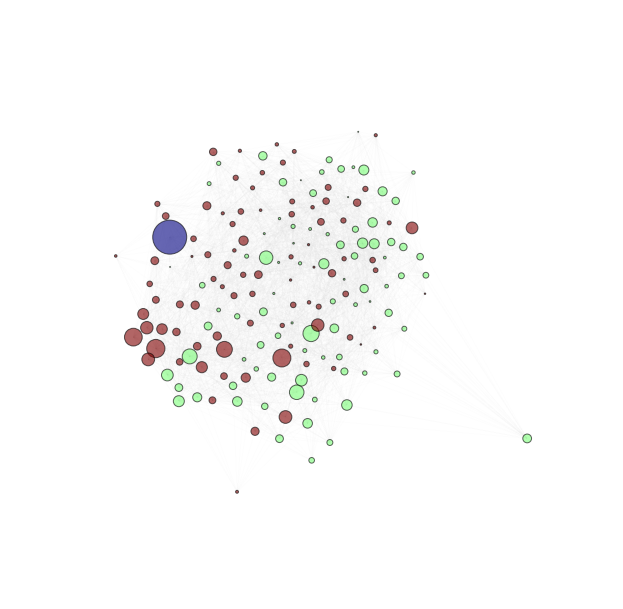

('0', 'S', '2', '2')


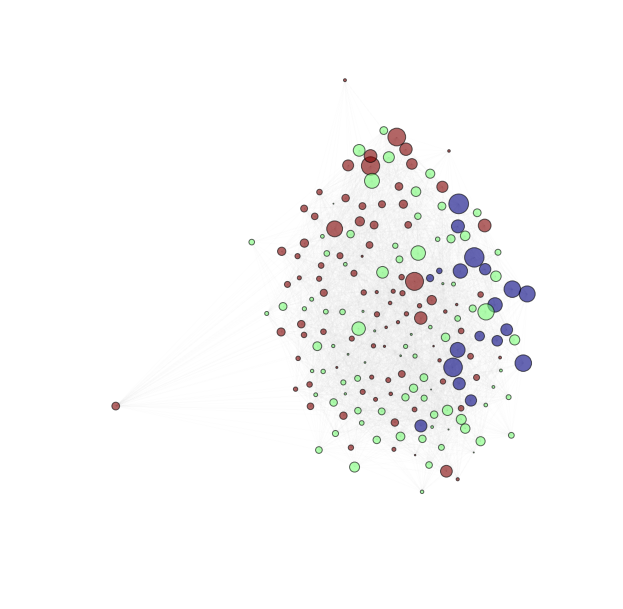

('GG', '0', '2', '2')


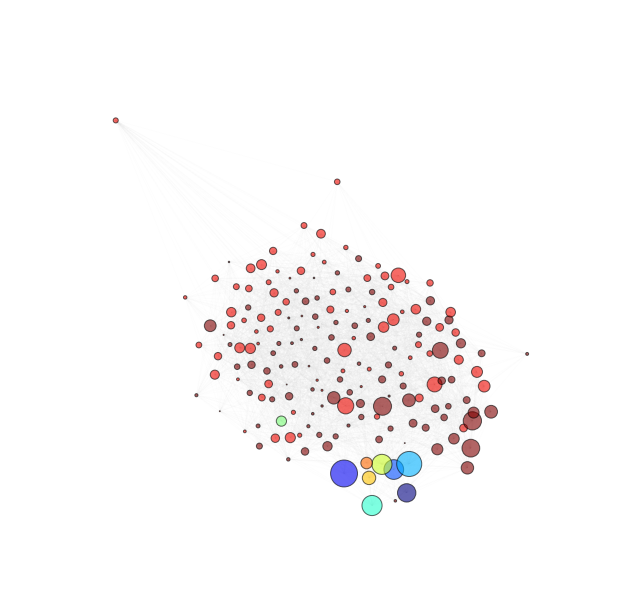

('GG', 'S', '2', '2')


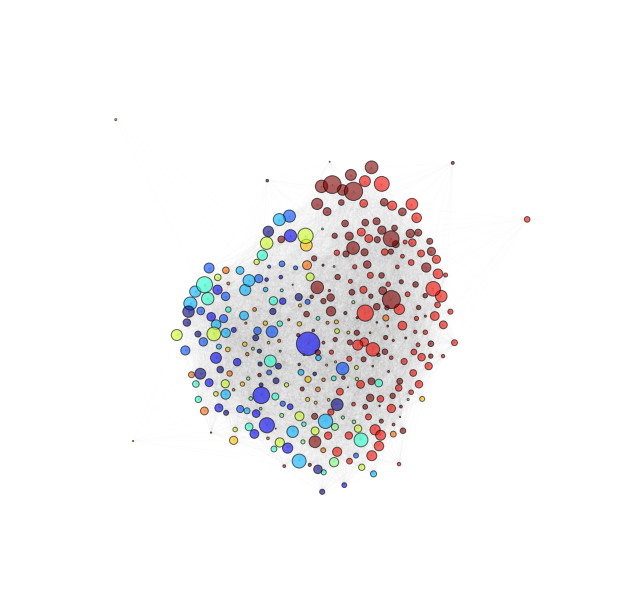

In [12]:
# Geo_lev = 'MER'

# trade_bra_4y_gl = trade_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'HS ID 4']).sum().reset_index()
# wages_bra_4y_gl = wages_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID F']).sum().reset_index()

for i in range(4):
    conf = confs[i]
    print conf

    dem_corr = demean_df(df_list[i].unstack())
    dem_corr.columns = dem_corr.columns.droplevel(0)

    ## standardizing after demeaning
    std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)    

    name = 'corr_'+Geo_lev+'_'+'_'.join([c for c in conf])

    df = pd.DataFrame(std_dem_corr.stack(), columns = [name])
    network_data = df[(df[name] > df[name].quantile(4/5.)) & (df[name] < df[name].quantile(.99))]
    network_data.index.names = ['label4_x', 'label_y']

    edges = network_data.reset_index().rename({name: 'weight'}, axis  =1)

    G = nx.from_pandas_dataframe(edges, 'label4_x', 'label_y', 'weight')
    col_name = 'corr_'+Geo_lev+'_'.join([c for c in confs[i]])
    nx.write_gexf(G, col_name+'.gexf')

    G_list += [G]
    # #Main component
    # grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    # G0=grcc[0]

    nodes = nodes_df_list[i].loc[G.nodes()]

    #Perform Graph Drawing
    plt.figure(figsize=(8, 8))
    posi = nx.spring_layout(G, k=0.15)
    node_sizes = np.sqrt(nodes['node_size'].values)
    colors = nodes.att_B.rank(method = 'dense').values

    # 

    nx.draw(G, posi, node_size = .001*node_sizes, alpha=.6, node_color= colors, edgelist = [])
    nx.draw_networkx_edges(G, posi, edge_color='.7', alpha=.02)
    #     plt.savefig('../DataViva/Figures/'+'_'+kw+'_'+name)
    plt.show()

('0', '0', '2', '2')


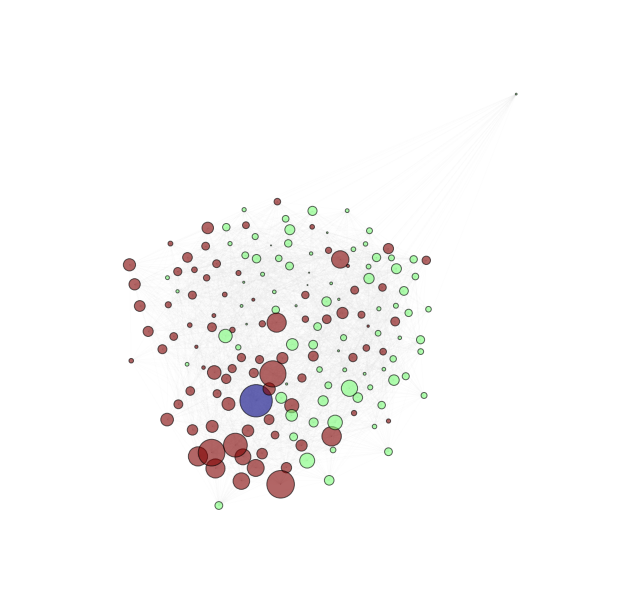

('0', 'S', '2', '2')


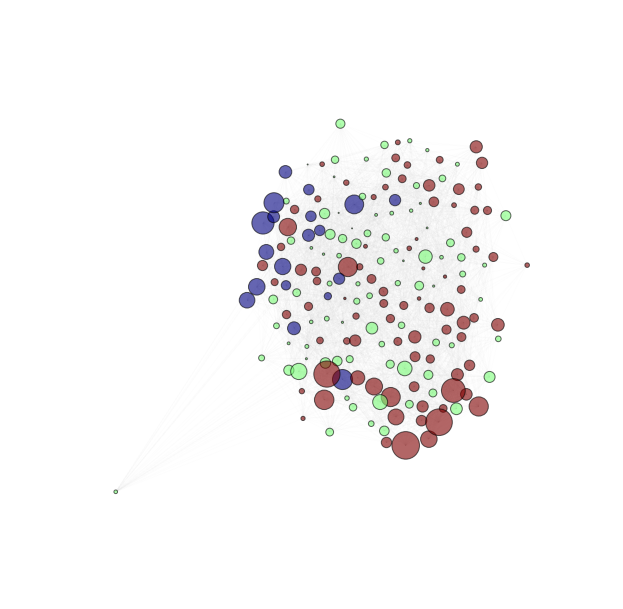

('GG', '0', '2', '2')


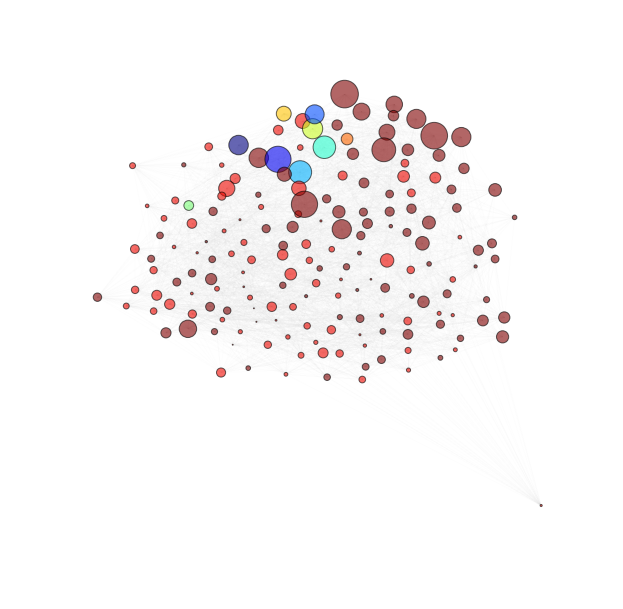

('GG', 'S', '2', '2')


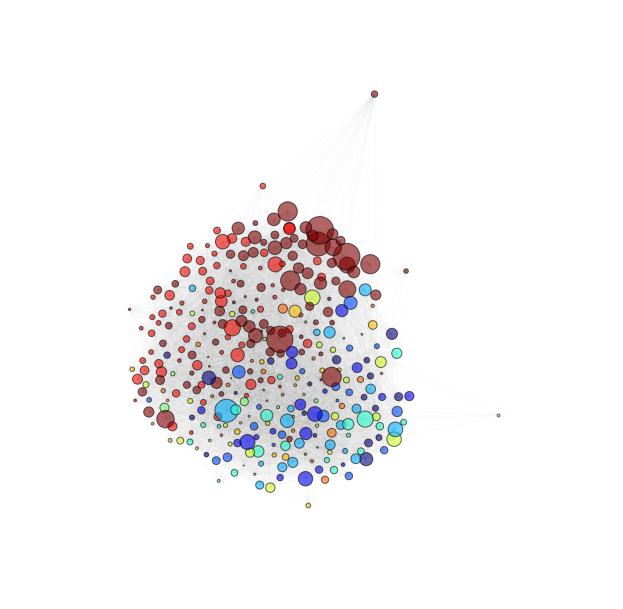

### Incorporate Bokeh

In [41]:
from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, NodesOnly

from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.palettes import Spectral4

i = 3

G=G_list[i]

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1))


nodes = nodes_df_list[i].loc[G.nodes()]
node_indices = range(len(nodes))
node_sizes = np.sqrt(nodes['node_size'].values)
node_names = nodes.reset_index().index
# colors = nodes.att_B.rank(method = 'dense').values
# nodes['color_code'] = nodes.att_B.rank(method = 'dense')

# import matplotlib

# x = plt.cm.get_cmap('rainbow', len(nodes.color_code.unique()))

# colors_hex = []
# for i in range(x.N):
#     rgb = x(i)[:3] # will return rgba, we take only first 3 so we get rgb
#     colors_hex += [matplotlib.colors.rgb2hex(rgb)]

# colors_hex = [x.encode('UTF8') for x in colors_hex]
# colors_df = pd.DataFrame([nodes.color_code.unique(), colors_hex], index = ['color_code', 'color']).T
# nodes = nodes.merge(colors_df)


hover = HoverTool(tooltips = [('Info', '@text'),
                          ('(x,y)', '($x, $y)')])

graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0,0), k = .15)

graph_renderer.node_renderer.data_source.data = dict(index=node_indices, text=list(nodes.index.values))
# color=list(nodes.color.values)

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color = Spectral4[2])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

plot.add_tools(hover)

output_file("networkx_graph.html")
# output_notebook()
show(plot)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)]
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='ed4f5d5d-0418-4120-bd11-79d191690967', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='d3efc66b-508b-4f4e-8532-8e537f95551e', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that

In [42]:
from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, NodesOnly

from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.palettes import Spectral4

i = 3

G=G_list[i]

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1))


nodes = nodes_df_list[i].loc[G.nodes()]
node_indices = range(len(nodes))
node_sizes = np.sqrt(nodes['node_size'].values)
node_names = nodes.reset_index().index
colors = nodes.att_B.rank(method = 'dense').values
nodes['color_code'] = nodes.att_B.rank(method = 'dense')

import matplotlib

x = plt.cm.get_cmap('rainbow', len(nodes.color_code.unique()))

colors_hex = []
for i in range(x.N):
    rgb = x(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_hex += [matplotlib.colors.rgb2hex(rgb)]

colors_df = pd.DataFrame([nodes.color_code.unique(), colors_hex], index = ['color_code', 'color']).T
nodes = nodes.merge(colors_df)

# Convert dataframe to column data source
src = ColumnDataSource(data = dict(index=nodes.index, text=nodes.index.values, color=nodes.color.values))
src.data.keys()

# Hover tool referring to our own data field using @ and
# a position on the graph using $
hover = HoverTool(tooltips = [('Info', '@text'),
                          ('(x,y)', '($x, $y)')])

graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0,0), k = .15)

graph_renderer.node_renderer.data_source = src
graph_renderer.node_renderer.data_source.add(node_indices, 'index')
# graph_renderer.node_renderer.data_source.add(, 'color')

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color='color')

graph_renderer.selection_policy = NodesAndLinkedEdges()

plot.renderers.append(graph_renderer)

output_file("networkx_graph.html")
# output_notebook()
show(plot)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)]
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='ed4f5d5d-0418-4120-bd11-79d191690967', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='d3efc66b-508b-4f4e-8532-8e537f95551e', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that

In [43]:
import networkx as nx

from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes, NodesOnly

from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.palettes import Spectral4

i = 3

# G=G_list[i]
G = nx.read_gexf('corr_MIR0_0_2_2.gexf')

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1))


nodes = nodes_df_list[i].loc[G.nodes()]
node_indices = range(len(nodes))
node_sizes = np.sqrt(nodes['node_size'].values)
node_names = nodes.reset_index().index
colors = nodes.att_B.rank(method = 'dense').values
nodes['color_code'] = nodes.att_B.rank(method = 'dense')

import matplotlib

x = plt.cm.get_cmap('rainbow', len(nodes.color_code.unique()))

colors_hex = []
for i in range(x.N):
    rgb = x(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_hex += [matplotlib.colors.rgb2hex(rgb)]

colors_df = pd.DataFrame([nodes.color_code.unique(), colors_hex], index = ['color_code', 'color']).T
nodes = nodes.merge(colors_df)

# # Convert dataframe to column data source
# src = ColumnDataSource(data = dict(index=node_indices, text=nodes.index.values, tag=nodes.att_A.values))
# src.data.keys()

# Hover tool referring to our own data field using @ and
# a position on the graph using $
hover = HoverTool(tooltips = [('Info', '@text'),
                          ('(x,y)', '($x, $y)')])

graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0,0), k = .15)

graph_renderer.node_renderer.data_source.data = dict(
    index=node_indices,
    text=nodes.index.values,
    color = nodes.color.values)
# graph_renderer.node_renderer.data_source.add(node_indices, 'index')
# graph_renderer.node_renderer.data_source.add(nodes.color.values, 'color')

graph_renderer.node_renderer.glyph = Circle(size=15)
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])


graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

plot.add_tools(hover)

output_file("networkx_graph.html")
# output_notebook()
show(plot)

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: color [renderer: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)]
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='c96bdd8a-7618-4442-a4f5-535f7527d549', ...)
ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='ed4f5d5d-0418-4120-bd11-79d191690967', ...)
ERROR:

In [49]:
from bokeh.palettes import Spectral8

In [106]:
graph_renderer.node_renderer.data_source.data.keys()

['text', 'index']

In [67]:
import matplotlib

x = plt.cm.get_cmap('rainbow', len(nodes.color_code.unique()))

colors_hex = []
for i in range(x.N):
    rgb = x(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors_hex += [matplotlib.colors.rgb2hex(rgb)]

colors_df = pd.DataFrame([nodes.color_code.unique(), colors_hex], index = ['color_code', 'color_hex']).T

# col_ref = col_ref.merge(colors_df)

In [69]:

.sample(10)
# nodes

,att_A,att_B,node_size,color_code,color_hex
271,Imports,Imports,1.118270e+09,11,#ff964f
186,Exports,Exports,1.197392e+06,10,#b3f396
179,Exports,Exports,4.650542e+08,10,#b3f396
185,Exports,Exports,2.290134e+08,10,#b3f396
80,F,7,3.955483e+10,7,#4df3ce
307,F,6,9.178043e+07,6,#ff4f28
251,Imports,Imports,3.550567e+08,11,#ff964f
264,Imports,Imports,9.707876e+08,11,#ff964f
286,Imports,Imports,2.452273e+10,11,#ff964f
258,Imports,Imports,3.067962e+09,11,#ff964f


In [3]:
# bokeh basics
from bokeh.plotting import figure
from bokeh.io import show, output_file

# Create a blank figure with labels
p = figure(plot_width = 600, plot_height = 600, 
           title = 'Example Glyphs',
           x_axis_label = 'X', y_axis_label = 'Y')

# Example data
squares_x = [1, 3, 4, 5, 8]
squares_y = [8, 7, 3, 1, 10]
circles_x = [9, 12, 4, 3, 15]
circles_y = [8, 4, 11, 6, 10]

# Add squares glyph
p.square(squares_x, squares_y, size = 12, color = 'navy', alpha = 0.6)
# Add circle glyph
p.circle(circles_x, circles_y, size = 12, color = 'red')

# Set to output the plot in the notebook
# output_notebook()
output_file("networkx_graph.html")
# Show the plot
show(p)

In [1]:
import networkx as nx

# i = 0
for i in range(4):
    conf = confs[i]
    print conf

    dem_corr = demean_df(df_list[i].unstack())
    dem_corr.columns = dem_corr.columns.droplevel(0)

    ## standardizing after demeaning
    std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)    

    name = 'corr_'+Geo_lev+'_'+'_'.join([c for c in conf])

    df = pd.DataFrame(std_dem_corr.stack(), columns = [name])
    network_data = df[(df[name] > df[name].quantile(4/5.)) & (df[name] < df[name].quantile(.99))]
    network_data.index.names = ['label_x', 'label_y']

    edges = network_data.reset_index().rename({name: 'weight'}, axis  =1)


    G = nx.from_pandas_dataframe(edges, 'label_x', 'label_y', 'weight')
    G_list +=[G]


    # #Main component
    # grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    # G0=grcc[0]

    nodes = nodes_df_list[i].loc[G.nodes()]

    #Perform Graph Drawing
    plt.figure(figsize=(8, 8))
    posi = nx.spring_layout(G, k=0.15)
    node_sizes = np.sqrt(nodes['node_size'].values)
    colors = nodes.att_A.rank(method = 'dense').values

    # 

    nx.draw(G, posi, node_size = .001*node_sizes, alpha=.6, node_color= colors, edgelist = [])
    nx.draw_networkx_edges(G, posi, edge_color='.7', alpha=.02)
    #     plt.savefig('../DataViva/Figures/'+'_'+kw+'_'+name)
    plt.show()

NameError: name 'confs' is not defined

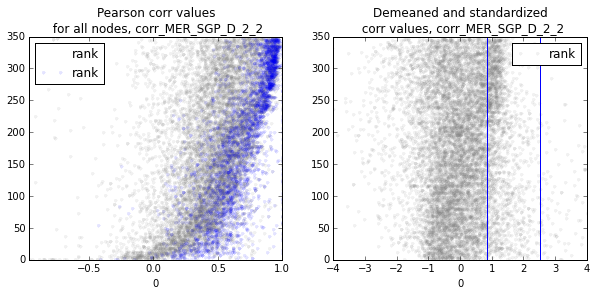

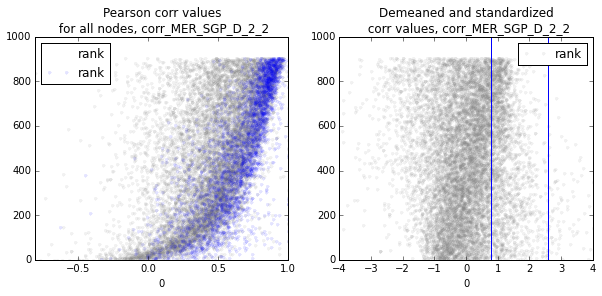

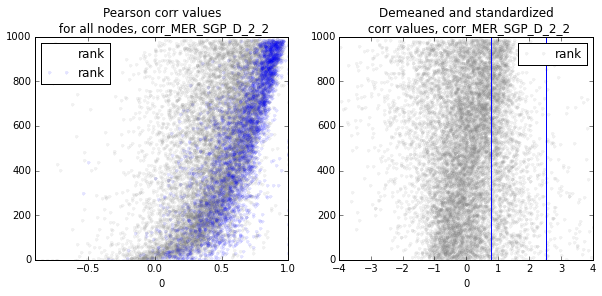

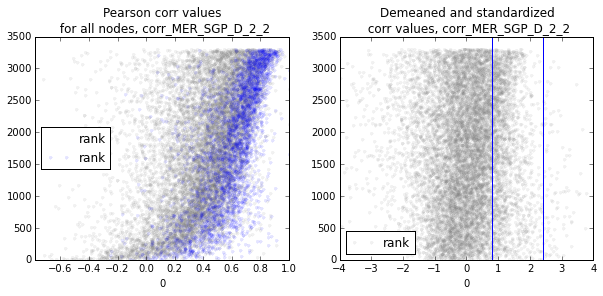

In [76]:
### PLOT CORR VALUES

for i in range(4):

    rk = pd.DataFrame(df_list[i].reset_index().groupby('level_0').mean().rank())
    rk.columns = ['rank']
    
    dem_corr = demean_df(df_list[i].unstack())
    dem_corr.columns = dem_corr.columns.droplevel(0)

    ## standardizing after demeaning
    std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0) 
    
    name = 'corr_'+Geo_lev+'_'+'_'.join([c for c in confs[i]])


    df_corr = df_list[i].reset_index().merge(rk.reset_index())
    df_corr.columns = [u'level_0', u'level_1', 0, u'rank']
    df_std_dem = std_dem_corr.stack().reset_index().merge(rk.reset_index())


    dfs = [df_corr, df_std_dem]
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))
    for i in range(2):
        df = dfs[i]
        ax = axs[i]
        df.sample(10000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', alpha = .1, ax = ax, color = '.5')

        if i == 0:
            ax.set_xlim(-.5, 1)
            ax.set_title('Pearson corr values \n for all nodes, ' +name)
            hilite = df_corr.loc[df_std_dem[0] > np.percentile(df_std_dem[0], 100 * 4/5.)]
            hilite.sample(3000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', ax = ax, alpha = .1)


        if i ==1:
            ax.axvline(x = df[0].quantile(4/5.), linestyle = '-', color = 'b')
            ax.axvline(x = df[0].quantile(.99), linestyle = '-', color = 'b')
            ax.set_xlim(-4, 4)
            ax.set_title('Demeaned and standardized \n corr values, '+name)
#             hilite = df_std_dem.loc[df_std_dem[0] > np.percentile(df_std_dem[0], 100 * 4/5.)]
#             hilite.sample(1000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', ax = ax)

    plt.show()



In [ ]:
#Node size info (maybe should be done when the node labels are set)

df = trade_bra.merge(HS[['HS ID 2', 'HS ID 4']].drop_duplicates()).groupby('HS ID 2').sum()
nds_y = nodes_df.loc[[row for row in nodes_df.index if 'Exports' in row]].reset_index().merge(df[['Exports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Exports' : 'value_USD'}, axis = 1)
nds_z = nodes_df.loc[[row for row in nodes_df.index if 'Imports' in row]].reset_index().merge(df[['Imports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Imports' : 'value_USD'}, axis = 1)

# df = wages_bra.merge(HS['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev].drop_duplicates()).groupby(['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()

nds_x = nodes_df.loc[[row for row in nodes_df.index if 'Wages' in row]].reset_index()
nds_x['value_USD'] = 1762904178 #shortcut

nodes_df = pd.concat([nds_x, nds_y, nds_z]).set_index('node_name')

# colors...
# nodes_df.merge(CNAE[['CNAE ID D', 'CNAE ID S']], left_on = 'att_A', right_on = 'CNAE ID D', how = 'left').sample(30)#.loc[G.nodes()]

In [ ]:



# nodes = data.groupby('label').sum()[['volume_USD']].dropna()





In [1]:
CNAE

NameError: name 'CNAE' is not defined

## Other

In [ ]:
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2', index = False)
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2_i')

In [ ]:
df = pd.read_csv('data/Corr/corr_MER_S_GG_2_2')

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
pp = sns.pairplot(df.sample(10000).dropna(), diag_kind="kde", markers="+",
             plot_kws=dict(s=50, edgecolor="b", linewidth=1, alpha = .01),
             diag_kws=dict(shade=True))
[[ax.set_ylim(-.5,1) for ax in ax_list] for ax_list in pp.axes]
x = [-.5, 1]
[[ax.plot(x,x, c = '.5', linestyle = '--') for ax in ax_list] for ax_list in pp.axes]

plt.show()